In [59]:
%matplotlib widget
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from tqdm import tqdm
from models import Net_4_layers_v1 as CurrentModel

Import data.

In [60]:
data_a = np.load("../data/dataset_all_V1_bootstrap_O3a.npy")
data_b = np.load("../data/dataset_all_V1_bootstrap_O3b.npy")
data_total = np.vstack([data_a, data_b])

Refering data.

In [61]:
pd.DataFrame(data_total)

,0,1,2,3,4,5,6
0,9.517451,7.082010,152.196493,30.715828,-0.144738,0.104227,4.0
1,23.934838,11.774585,67.339999,7.718377,-0.861250,-0.467627,1.0
2,8.322346,5.146934,93.468914,17.888047,-0.203238,-0.012615,4.0
3,9.122890,11.532085,325.987187,45.616315,0.129675,0.135129,3.0
4,11.770522,6.543893,59.974914,6.295871,-0.770255,-0.284936,1.0
...,...,...,...,...,...,...,...
46795,15.208135,16.689965,73.212873,9.390564,0.108179,0.112250,2.0
46796,4.233904,1.076624,63.777395,11.814693,0.190787,-0.057725,0.0
46797,5.026195,1.432085,46.993963,4.891975,0.714362,-0.165378,0.0
46798,63.441778,170.114356,76.599024,9.332361,-0.533035,-0.362329,2.0


Divide data into training set, validating set and testing set.

In [64]:
data_length = len(data_total)

training_set_length = int(data_length * 0.7)
validating_set_length = int(data_length * 0.2)
testing_set_length = data_length - training_set_length - validating_set_length

training_set = data_total[0:training_set_length, :]
validating_set = data_total[training_set_length:training_set_length + validating_set_length, :]
testing_set = data_total[training_set_length+validating_set_length:, :]

Determine the device.

In [65]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Make the data suitable to pytorch.

In [66]:
input_tensor_training = torch.tensor(training_set[:, 0:6], dtype=torch.float32).to(device)
label_tensor_training = torch.tensor(training_set[:, 6], dtype=torch.int64).to(device)

input_tensor_validating = torch.tensor(validating_set[:, 0:6], dtype=torch.float32).to(device)
label_tensor_validating = torch.tensor(validating_set[:, 6], dtype=torch.int64).to(device)

input_tensor_testing = torch.tensor(testing_set[:, 0:6], dtype=torch.float32).to(device)
label_tensor_testing = torch.tensor(testing_set[:, 6], dtype=torch.int64).to(device)

dataset_training = TensorDataset(input_tensor_training, label_tensor_training)
dataset_validating = TensorDataset(input_tensor_validating, label_tensor_validating)
dataset_testing = TensorDataset(input_tensor_testing, label_tensor_testing)

loader_training = DataLoader(dataset_training, batch_size=32, shuffle=True)
loader_validating = DataLoader(dataset_validating, batch_size=32, shuffle=True)
loader_testing = DataLoader(dataset_testing, batch_size=32, shuffle=True)

Define the model, criterion and optimizer.

In [67]:
model = CurrentModel().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = 0.00025)


In [68]:
import torch
import torch.nn.functional as F

#Your training loop
loss_average_list = []
accuracy_average_list = []
valid_loss_average_list = []
valid_accuracy_average_list = []
test_loss_average_list = []
test_accuracy_average_list = []

for epoch in tqdm(range(1000), desc="Training ..."):
    model.train()  # Set the model to training mode
    correct_predictions = 0
    total_samples = 0
    loss_array = []

    for data in loader_training:
        inputs, labels = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        loss_array.append(loss.item())

        _, predicted = torch.max(outputs, 1)
        correct_predictions += (predicted == labels).sum().item()
        total_samples += labels.size(0)

    loss_average = sum(loss_array) / len(loss_array)
    accuracy_average = correct_predictions / total_samples
    loss_average_list.append(loss_average)
    accuracy_average_list.append(accuracy_average)

    #validation loop
    model.eval()  
    correct_predictions_valid = 0
    total_samples_valid = 0
    loss_array_valid = []

    with torch.no_grad():  # Disable gradient computation during testing
        for data in loader_validating:
            inputs_test, labels_test = data[0].to(device), data[1].to(device)
            outputs_test = model(inputs_test)
            loss_test = criterion(outputs_test, labels_test)
            loss_array_valid.append(loss_test.item())

            _, predicted_test = torch.max(outputs_test, 1)
            correct_predictions_valid += (predicted_test == labels_test).sum().item()
            total_samples_valid += labels_test.size(0)

    loss_average_valid = sum(loss_array_valid) / len(loss_array_valid)
    accuracy_average_valid = correct_predictions_valid / total_samples_valid

    valid_loss_average_list.append(loss_average_valid)
    valid_accuracy_average_list.append(accuracy_average_valid)

    # Testing loop
    model.eval()
    correct_predictions_test = 0
    total_samples_test = 0
    loss_array_test = []
    probabilities_class_1_test = []  # To store probabilities for class 1

    with torch.no_grad():  # Disable gradient computation during testing
        for data_test in loader_testing:
            inputs_test, labels_test = data_test[0].to(device), data_test[1].to(device)
            outputs_test = model(inputs_test)
            loss_test = criterion(outputs_test, labels_test)
            loss_array_test.append(loss_test.item())

            probabilities_test = F.softmax(outputs_test, dim=1)  # Apply softmax to get probabilities
            # Extract probabilities for class 1
            probabilities_class_1_test.extend(probabilities_test[:, 1].cpu().numpy())

            _, predicted_test = torch.max(outputs_test, 1)
            correct_predictions_test += (predicted_test == labels_test).sum().item()
            total_samples_test += labels_test.size(0)

    loss_average_test = sum(loss_array_test) / len(loss_array_test)
    accuracy_average_test = correct_predictions_test / total_samples_test

    test_loss_average_list.append(loss_average_test)
    test_accuracy_average_list.append(accuracy_average_test)

Training ...: 100%|██████████| 1000/1000 [13:54<00:00,  1.20it/s]


Plot the loss and average.

In [25]:
#with open('AdamSoftmaxVLoss.txt', 'w') as file:
 #   file.write('\n'.join(map(str, loss_average_list)))
    
#with open('AdamSoftmaxVAcc.txt', 'w') as file:
 #   file.write('\n'.join(map(str, accuracy_average_list)))

#with open('AdamSoftmaxVTestLoss.txt', 'w') as file:
 #   file.write('\n'.join(map(str, valid_loss_average_list)))
    
#with open('AdamSoftmaxVTestAcc.txt', 'w') as file:
 #   file.write('\n'.join(map(str, valid_accuracy_average_list)))

In [69]:
values = [loss_average_list[-1],accuracy_average_list[-1],valid_loss_average_list[-1],valid_accuracy_average_list[-1],test_loss_average_list[-1],test_accuracy_average_list[-1]]
print(values)

[0.11354691532869765, 0.9614151836136634, 0.18825383044766586, 0.951602564102564, 0.19233378495539533, 0.945951719718009]


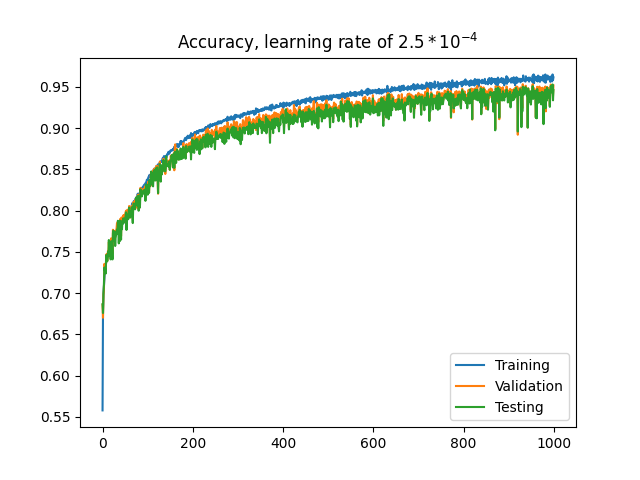

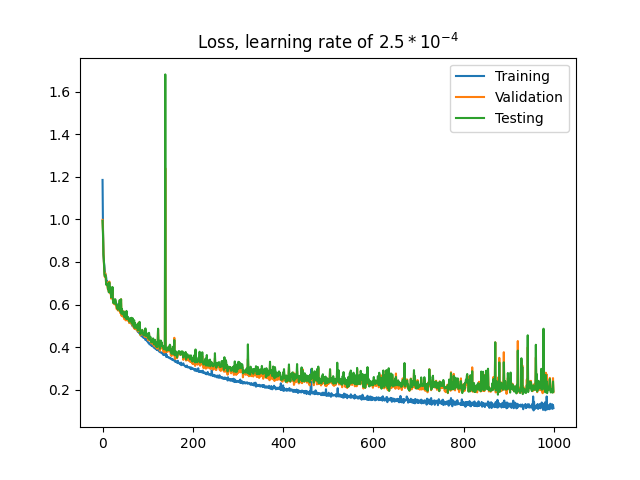

In [73]:
import matplotlib.pyplot as plt

fig1, ax1 = plt.subplots()
ax1.plot(loss_average_list, label="Training")
ax1.plot(valid_loss_average_list, label="Validation")
ax1.plot(test_loss_average_list, label="Testing")

#ax1.set_yscale("log")
ax1.legend()
ax1.set_title("Loss, learning rate of $2.5*10^{-4}$")


fig2, ax2 = plt.subplots()
ax2.plot(accuracy_average_list, label="Training")
ax2.plot(valid_accuracy_average_list, label="Validation")
ax2.plot(test_accuracy_average_list, label="Testing")
ax2.legend()
ax2.set_title("Accuracy, learning rate of $2.5*10^{-4}$")

#fig3,ax3 = plt.subplot(probabilities_class_1_test)
#ax3.plot()


plt.show()

Judge the model.

In [24]:
model.eval()
all_predictions = []
all_labels = []

In [25]:
with torch.no_grad():
    for inputs, labels in loader_training:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        all_predictions.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

Calculate accuracy.

In [26]:
accuracy = accuracy_score(all_labels, all_predictions)
print(f"Accuracy: {accuracy}")

Accuracy: 0.8292248919272143


In [27]:
print(classification_report(all_labels, all_predictions))

              precision    recall  f1-score   support

           0       0.74      0.56      0.64     28419
           1       0.97      0.90      0.93     28427
           2       0.96      0.94      0.95     28427
           3       0.73      0.81      0.77     28405
           4       0.81      0.84      0.83     28374
           5       0.85      0.95      0.90     28469
           6       0.75      0.81      0.78     28419

    accuracy                           0.83    198940
   macro avg       0.83      0.83      0.83    198940
weighted avg       0.83      0.83      0.83    198940



In [28]:
print(confusion_matrix(all_labels, all_predictions))

[[15825   337   385  4489  2605  2431  2347]
 [  647 25623   145   886   105   958    63]
 [  289   198 26641   108   736   316   139]
 [ 1869    69     0 22892   193   797  2585]
 [ 1126    76   369   287 23931    18  2567]
 [  400     0     0   884     0 27109    76]
 [ 1233   120   155  1832  1850   284 22945]]


Model name.

In [17]:
model_name = "test"

Save the model.

In [18]:
torch.save(model.state_dict(), "../src/" + model_name)

Load the model.

In [19]:
model = CurrentModel().to(device)
model.load_state_dict(torch.load("../src/" + model_name))

<All keys matched successfully>